In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter

In [125]:
# Read in CSV file

df = pd.read_csv('plate9290_RVs.csv').drop(['Unnamed: 0', 'Plate ID'], axis=1)

In [205]:
df = df.sort_values(['Target ID'], ascending=True)

In [206]:
df

,Target ID,MJD,OBSVHELIO (km/s),Avg RV,ΔRV
0,apo25m.5226.150-08-RV.2M03252400+4614203,57706,-86.565704,-86.460343,-0.105361
15,apo25m.5226.150-08-RV.2M03252400+4614203,58143,-86.096080,-86.460343,0.364263
14,apo25m.5226.150-08-RV.2M03252400+4614203,58114,-86.530830,-86.460343,-0.070487
13,apo25m.5226.150-08-RV.2M03252400+4614203,58087,-86.532440,-86.460343,-0.072097
12,apo25m.5226.150-08-RV.2M03252400+4614203,58085,-86.569565,-86.460343,-0.109222
...,...,...,...,...,...
3617,apo25m.5226.150-08-RV.2M03415658+4626067,57732,-26.530085,-26.555161,0.025076
3616,apo25m.5226.150-08-RV.2M03415658+4626067,57706,-26.743143,-26.555161,-0.187982
3630,apo25m.5226.150-08-RV.2M03415658+4626067,58114,-26.599243,-26.555161,-0.044082
3622,apo25m.5226.150-08-RV.2M03415658+4626067,57789,-26.565876,-26.555161,-0.010715


## Step 1
- Plot ΔRV against MJD, try to locate pattern

## To Do
- ~For unique target in total df, create df for just that target's data~
- ~Take RV data for each target and calculate avg~
- ~For each RV data point in each df, find ΔRV = RV - RVavg~
- ~Combine all ΔRVs for all dfs, add to total df~
- ~Plot y=ΔRV, x=MJD~

In [207]:
# Identify list of unique targets

unique_targets = Counter(df['Target ID'])
unique_targets_list = unique_targets.keys()

In [208]:
unique_targets

Counter({'apo25m.5226.150-08-RV.2M03252400+4614203': 16,
         'apo25m.5226.150-08-RV.2M03254141+4609481': 16,
         'apo25m.5226.150-08-RV.2M03260338+4545080': 16,
         'apo25m.5226.150-08-RV.2M03262343+4632226': 16,
         'apo25m.5226.150-08-RV.2M03262567+4559489': 16,
         'apo25m.5226.150-08-RV.2M03262827+4610388': 16,
         'apo25m.5226.150-08-RV.2M03263128+4648154': 16,
         'apo25m.5226.150-08-RV.2M03263984+4522118': 16,
         'apo25m.5226.150-08-RV.2M03264360+4555595': 16,
         'apo25m.5226.150-08-RV.2M03264878+4622091': 16,
         'apo25m.5226.150-08-RV.2M03264888+4530001': 16,
         'apo25m.5226.150-08-RV.2M03265861+4649514': 16,
         'apo25m.5226.150-08-RV.2M03270027+4532373': 16,
         'apo25m.5226.150-08-RV.2M03270048+4603439': 16,
         'apo25m.5226.150-08-RV.2M03270057+4636386': 16,
         'apo25m.5226.150-08-RV.2M03270785+4519348': 16,
         'apo25m.5226.150-08-RV.2M03270863+4534486': 16,
         'apo25m.5226.150-08-RV

In [209]:
len(unique_targets)

227

In [222]:
# Obtain average RV and ΔRV for each target
# Find better way to do this!

all_delta_rvs = []
all_avg_rvs = []

for target in unique_targets_list:
    target_df = df[df['Target ID'] == target]
    print('Single Target DF:', target_df)
    target_rvs = list(target_df['OBSVHELIO (km/s)'])
    print('All RVs for Target:', target_rvs)
    avg_rv = sum(list(target_df['OBSVHELIO (km/s)'])) / len(target_df['OBSVHELIO (km/s)']) # Should be 16
    print('RV Sum:', sum(list(target_df['OBSVHELIO (km/s)'])))
    print('RV Count:', len(target_df['OBSVHELIO (km/s)']))
    print('Avg RV:', avg_rv)
    print('Abs Avg RV:', abs(avg_rv))
    delta_rvs = []
    for trv in target_rvs:
        delta_rv = abs(avg_rv) - abs(trv) # Should this be an abs value?
        delta_rvs.append(delta_rv)
        all_avg_rvs.append(avg_rv)
        # print(abs(trv))
        # print(delta_rv)
    # print(target_rvs)
    all_delta_rvs.append(delta_rvs)
    # print(avg_rv)

Single Target DF:                                    Target ID    MJD  OBSVHELIO (km/s)  \
0   apo25m.5226.150-08-RV.2M03252400+4614203  57706        -86.565704   
15  apo25m.5226.150-08-RV.2M03252400+4614203  58143        -86.096080   
14  apo25m.5226.150-08-RV.2M03252400+4614203  58114        -86.530830   
13  apo25m.5226.150-08-RV.2M03252400+4614203  58087        -86.532440   
12  apo25m.5226.150-08-RV.2M03252400+4614203  58085        -86.569565   
10  apo25m.5226.150-08-RV.2M03252400+4614203  58063        -86.519880   
9   apo25m.5226.150-08-RV.2M03252400+4614203  58054        -86.564070   
8   apo25m.5226.150-08-RV.2M03252400+4614203  58032        -86.379560   
11  apo25m.5226.150-08-RV.2M03252400+4614203  58068        -86.524210   
6   apo25m.5226.150-08-RV.2M03252400+4614203  57789        -86.457430   
5   apo25m.5226.150-08-RV.2M03252400+4614203  57788        -86.563065   
4   apo25m.5226.150-08-RV.2M03252400+4614203  57760        -86.366640   
3   apo25m.5226.150-08-RV.2M03252

Abs Avg RV: 35.161977625000006
Single Target DF:                                      Target ID    MJD  OBSVHELIO (km/s)  \
1391  apo25m.5226.150-08-RV.2M03312658+4549449  58143        -60.388065   
1390  apo25m.5226.150-08-RV.2M03312658+4549449  58114        -60.515118   
1389  apo25m.5226.150-08-RV.2M03312658+4549449  58087        -60.278370   
1388  apo25m.5226.150-08-RV.2M03312658+4549449  58085        -60.403340   
1387  apo25m.5226.150-08-RV.2M03312658+4549449  58068        -60.318990   
1386  apo25m.5226.150-08-RV.2M03312658+4549449  58063        -60.255608   
1385  apo25m.5226.150-08-RV.2M03312658+4549449  58054        -60.297455   
1384  apo25m.5226.150-08-RV.2M03312658+4549449  58032        -60.614624   
1383  apo25m.5226.150-08-RV.2M03312658+4549449  58006        -60.171043   
1381  apo25m.5226.150-08-RV.2M03312658+4549449  57788        -60.848038   
1380  apo25m.5226.150-08-RV.2M03312658+4549449  57760        -60.261787   
1379  apo25m.5226.150-08-RV.2M03312658+4549449  577

2592  1.80061  0.120659  
All RVs for Target: [1.8778438999999998, 1.8619823, 2.0134711, 1.8361737, 1.8268328, 1.8409033, 1.7348728, 1.6983986, 1.7666721, 1.7017441000000002, 1.8549156000000002, 1.7717304, 1.829278, 1.7393379, 1.7756557000000002, 1.6799509999999998]
RV Sum: 28.809763299999997
RV Count: 16
Avg RV: 1.8006102062499998
Abs Avg RV: 1.8006102062499998
Single Target DF:                                      Target ID    MJD  OBSVHELIO (km/s)  \
2616  apo25m.5226.150-08-RV.2M03362521+4626153  58032        -47.567223   
2623  apo25m.5226.150-08-RV.2M03362521+4626153  58143        -47.647575   
2622  apo25m.5226.150-08-RV.2M03362521+4626153  58114        -47.701126   
2621  apo25m.5226.150-08-RV.2M03362521+4626153  58087        -47.526325   
2620  apo25m.5226.150-08-RV.2M03362521+4626153  58085        -47.597553   
2619  apo25m.5226.150-08-RV.2M03362521+4626153  58068        -47.484013   
2618  apo25m.5226.150-08-RV.2M03362521+4626153  58063        -47.461403   
2617  apo25m.5226

In [211]:
# Flatten list of all ΔRVs

flat_all_delta_rvs = [item for sublist in all_delta_rvs for item in sublist]
# flat_all_delta_rvs

In [212]:
max(flat_all_delta_rvs)

250004.225713775

In [213]:
# Add average RV and ΔRV columns to dataframe

df['Avg RV'] = all_avg_rvs
df['ΔRV'] = flat_all_delta_rvs

In [214]:
# Updated dataframe!

df

,Target ID,MJD,OBSVHELIO (km/s),Avg RV,ΔRV
0,apo25m.5226.150-08-RV.2M03252400+4614203,57706,-86.565704,-86.460343,-0.105361
15,apo25m.5226.150-08-RV.2M03252400+4614203,58143,-86.096080,-86.460343,0.364263
14,apo25m.5226.150-08-RV.2M03252400+4614203,58114,-86.530830,-86.460343,-0.070487
13,apo25m.5226.150-08-RV.2M03252400+4614203,58087,-86.532440,-86.460343,-0.072097
12,apo25m.5226.150-08-RV.2M03252400+4614203,58085,-86.569565,-86.460343,-0.109222
...,...,...,...,...,...
3617,apo25m.5226.150-08-RV.2M03415658+4626067,57732,-26.530085,-26.555161,0.025076
3616,apo25m.5226.150-08-RV.2M03415658+4626067,57706,-26.743143,-26.555161,-0.187982
3630,apo25m.5226.150-08-RV.2M03415658+4626067,58114,-26.599243,-26.555161,-0.044082
3622,apo25m.5226.150-08-RV.2M03415658+4626067,57789,-26.565876,-26.555161,-0.010715


<AxesSubplot:xlabel='MJD', ylabel='ΔRV'>

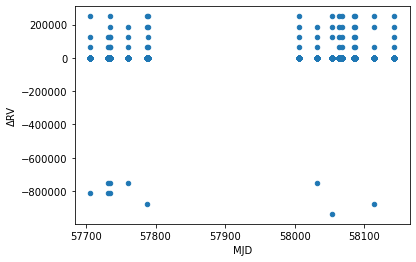

In [95]:
# Initial plot - lots of unexpected outliers?

df.plot(x = 'MJD', y = 'ΔRV', kind = 'scatter')

## Questions
- What is causing the weird outliers?
- What should be done about them?

## Step 2
- Adjust plot, check for visible pattern
- If no pattern, try PCA

In [234]:
# Check ΔRV values

df.sort_values(['ΔRV'], ascending=True)

,Target ID,MJD,OBSVHELIO (km/s),Avg RV,ΔRV
841,apo25m.5226.150-08-RV.2M03294546+4531510,58054,999999.0,62470.779686,-937528.220314
1566,apo25m.5226.150-08-RV.2M03320675+4519114,58114,999999.0,125012.080229,-874986.919771
1557,apo25m.5226.150-08-RV.2M03320675+4519114,57788,999999.0,125012.080229,-874986.919771
2129,apo25m.5226.150-08-RV.2M03340241+4638066,57732,999999.0,187490.120951,-812508.879049
2128,apo25m.5226.150-08-RV.2M03340241+4638066,57706,999999.0,187490.120951,-812508.879049
...,...,...,...,...,...
1053,apo25m.5226.150-08-RV.2M03302697+4703478,58087,0.0,250004.225714,250004.225714
1052,apo25m.5226.150-08-RV.2M03302697+4703478,58085,0.0,250004.225714,250004.225714
1051,apo25m.5226.150-08-RV.2M03302697+4703478,58068,0.0,250004.225714,250004.225714
1049,apo25m.5226.150-08-RV.2M03302697+4703478,58054,0.0,250004.225714,250004.225714


In [235]:
# Show bad values

df[df['Avg RV'] > 100]

,Target ID,MJD,OBSVHELIO (km/s),Avg RV,ΔRV
841,apo25m.5226.150-08-RV.2M03294546+4531510,58054,999999.000000,62470.779686,-937528.220314
846,apo25m.5226.150-08-RV.2M03294546+4531510,58114,-34.726265,62470.779686,62436.053421
845,apo25m.5226.150-08-RV.2M03294546+4531510,58087,-49.396343,62470.779686,62421.383343
844,apo25m.5226.150-08-RV.2M03294546+4531510,58085,-33.324802,62470.779686,62437.454884
843,apo25m.5226.150-08-RV.2M03294546+4531510,58068,-4.026879,62470.779686,62466.752807
...,...,...,...,...,...
2130,apo25m.5226.150-08-RV.2M03340241+4638066,57734,999999.000000,187490.120951,-812508.879049
2135,apo25m.5226.150-08-RV.2M03340241+4638066,58006,-12.611349,187490.120951,187477.509602
2132,apo25m.5226.150-08-RV.2M03340241+4638066,57760,-9.671673,187490.120951,187480.449278
2133,apo25m.5226.150-08-RV.2M03340241+4638066,57788,-10.598166,187490.120951,187479.522785


In [236]:
# Drop bad values

df_cutoff = df[df['Avg RV'] < 100]
df_cutoff.sort_values(['Avg RV'], ascending=False)

,Target ID,MJD,OBSVHELIO (km/s),Avg RV,ΔRV
1143,apo25m.5226.150-08-RV.2M03303764+4658476,58006,69.291336,69.298957,0.007621
1151,apo25m.5226.150-08-RV.2M03303764+4658476,58143,69.407870,69.298957,-0.108913
1147,apo25m.5226.150-08-RV.2M03303764+4658476,58068,69.426580,69.298957,-0.127623
1146,apo25m.5226.150-08-RV.2M03303764+4658476,58063,69.468094,69.298957,-0.169137
1145,apo25m.5226.150-08-RV.2M03303764+4658476,58054,69.230255,69.298957,0.068702
...,...,...,...,...,...
395,apo25m.5226.150-08-RV.2M03281525+4636079,58068,-104.073670,-104.032626,-0.041044
396,apo25m.5226.150-08-RV.2M03281525+4636079,58085,-104.152390,-104.032626,-0.119764
397,apo25m.5226.150-08-RV.2M03281525+4636079,58087,-103.987430,-104.032626,0.045196
393,apo25m.5226.150-08-RV.2M03281525+4636079,58054,-103.938790,-104.032626,0.093836


<AxesSubplot:xlabel='MJD', ylabel='ΔRV'>

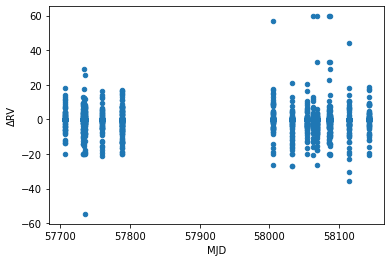

In [256]:
# New plot with only good values

df_cutoff.plot(x = 'MJD', y = 'ΔRV', kind = 'scatter') #, figsize=(15, 15))

In [283]:
df_cutoff1 = df_cutoff.loc[(df_cutoff['ΔRV'] < 0.5) & (df_cutoff['ΔRV'] > -0.5)]

<AxesSubplot:xlabel='MJD', ylabel='ΔRV'>

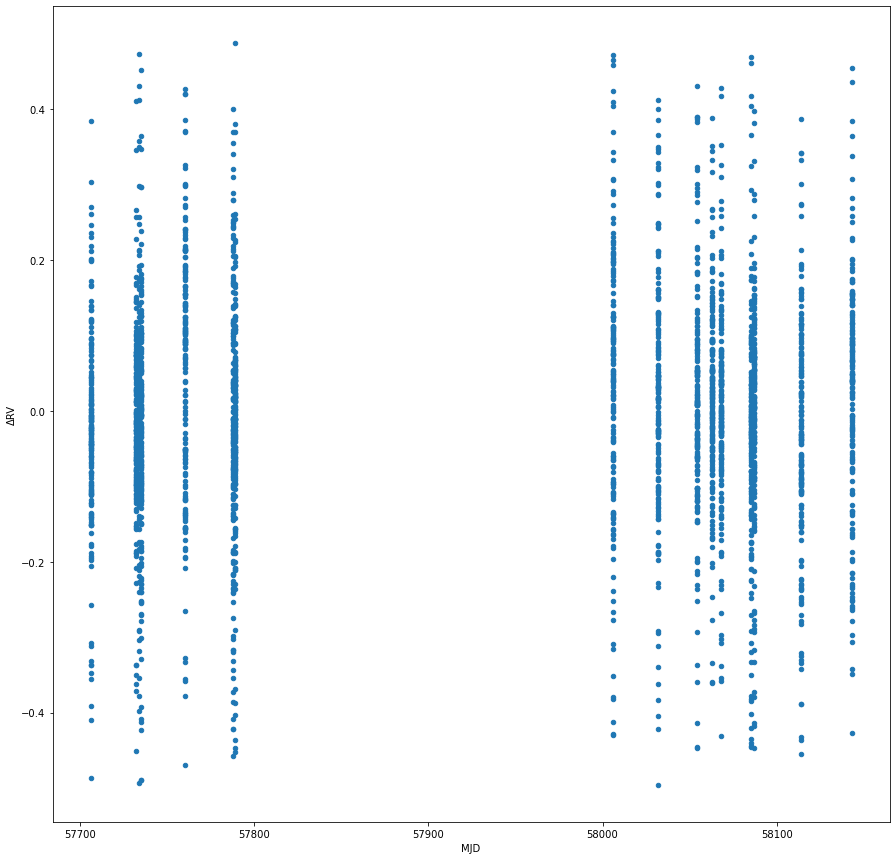

In [284]:
df_cutoff1.plot(x='MJD', y='ΔRV', kind='scatter', figsize=(15,15))

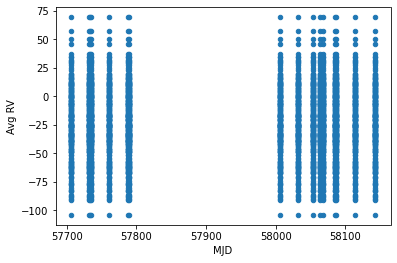

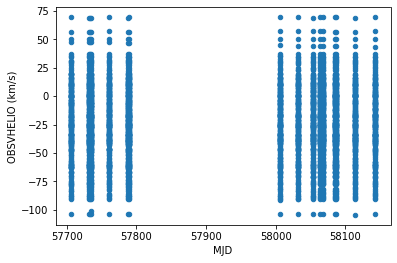

In [240]:
# Plots of avg RVs and all RVs

rv_avg_plot = df_cutoff.plot(x = 'MJD', y = 'Avg RV', kind = 'scatter')
rv_all_plot = df_cutoff.plot(x = 'MJD', y = 'OBSVHELIO (km/s)', kind = 'scatter')

In [106]:
df_test = df[df['Target ID'] == 'apo25m.5226.150-08-RV.2M03252400+4614203']

In [107]:
df_test

,Target ID,MJD,OBSVHELIO (km/s),ΔRV
0,apo25m.5226.150-08-RV.2M03252400+4614203,57706,-86.565704,-0.105361
1,apo25m.5226.150-08-RV.2M03252400+4614203,57732,-86.383430,0.076913
2,apo25m.5226.150-08-RV.2M03252400+4614203,57734,-86.386870,0.073473
3,apo25m.5226.150-08-RV.2M03252400+4614203,57735,-86.532840,-0.072497
4,apo25m.5226.150-08-RV.2M03252400+4614203,57760,-86.366640,0.093703
5,apo25m.5226.150-08-RV.2M03252400+4614203,57788,-86.563065,-0.102722
6,apo25m.5226.150-08-RV.2M03252400+4614203,57789,-86.457430,0.002913
7,apo25m.5226.150-08-RV.2M03252400+4614203,58006,-86.392876,0.067467
8,apo25m.5226.150-08-RV.2M03252400+4614203,58032,-86.379560,0.080783
9,apo25m.5226.150-08-RV.2M03252400+4614203,58054,-86.564070,-0.103727


<AxesSubplot:xlabel='MJD', ylabel='ΔRV'>

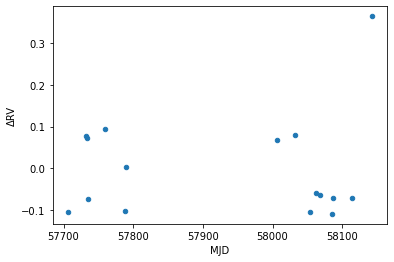

In [108]:
df_test.plot(x = 'MJD', y = 'ΔRV', kind = 'scatter')

### Try PCA

In [311]:
features = ['MJD', 'ΔRV']

In [312]:
x2 = df.loc[:, features].values

In [313]:
y2 = df.loc[:, ['Target ID']].values

In [314]:
x2 = StandardScaler().fit_transform(x2)

In [315]:
x2.shape

(3632, 2)

In [317]:
# Check standard dev is 1.0

np.mean(x2), np.std(x2)

(1.5883323015861432e-18, 1.0)

In [301]:
feat_cols = ['feature'+str(i) for i in range(x2.shape[1])]

In [302]:
normalised_data = pd.DataFrame(x2,columns=feat_cols)

In [303]:
normalised_data.tail()

,feature0,feature1
3627,-1.212567,0.000014
3628,-1.370993,0.000009
3629,1.115074,0.000012
3630,-0.865249,0.000013
3631,1.291780,0.000016


In [304]:
pca = PCA(n_components = 2)

In [305]:
principalComponents = pca.fit_transform(x2)

In [306]:
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])

In [307]:
principalDf.tail()

,principal component 1,principal component 2
3627,0.857405,-0.857424
3628,0.969432,-0.969445
3629,-0.788485,0.788468
3630,0.611814,-0.611832
3631,-0.913437,0.913415


In [308]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.51636992 0.48363008]


<Figure size 432x288 with 0 Axes>

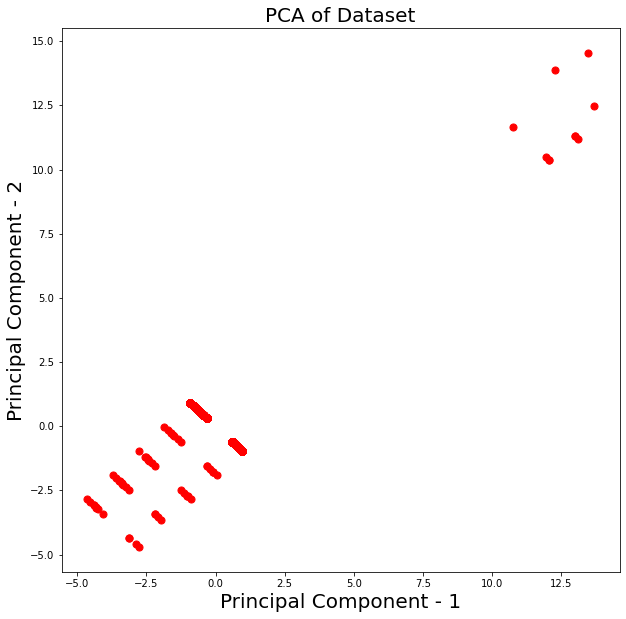

In [310]:
plt.figure()
plt.figure(figsize=(10,10))
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("PCA of Dataset",fontsize=20)
targets = [df['Target ID']]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df['Target ID'] == target
    plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

# plt.legend(targets,prop={'size': 15})

In [165]:
finalDf = pd.concat([principalDf, df[['Target ID']]], axis = 1)

In [166]:
finalDf

,principal component 1,principal component 2,Target ID
0,-0.018731,-1.022855,apo25m.5226.150-08-RV.2M03252400+4614203
1,-0.025336,-0.914397,apo25m.5226.150-08-RV.2M03252400+4614203
2,-0.025844,-0.906054,apo25m.5226.150-08-RV.2M03252400+4614203
3,-0.026098,-0.901884,apo25m.5226.150-08-RV.2M03252400+4614203
4,-0.032449,-0.797598,apo25m.5226.150-08-RV.2M03252400+4614203
...,...,...,...
3627,-0.109078,0.488988,apo25m.5226.150-08-RV.2M03415658+4626067
3628,-0.113397,0.559901,apo25m.5226.150-08-RV.2M03415658+4626067
3629,-0.113905,0.568244,apo25m.5226.150-08-RV.2M03415658+4626067
3630,-0.120764,0.680872,apo25m.5226.150-08-RV.2M03415658+4626067
